<a href="https://colab.research.google.com/github/andryll/MGR-IC/blob/main/codes/MGR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Setup


In [20]:
import numpy as np
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import neighbors
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.decomposition import PCA

In [2]:
!git clone https://github.com/andryll/MGR-IC.git

Cloning into 'MGR-IC'...
remote: Enumerating objects: 1064, done.
remote: Counting objects: 100% (65/65), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 1064 (delta 20), reused 8 (delta 0), pack-reused 999
Receiving objects: 100% (1064/1064), 1.13 GiB | 30.94 MiB/s, done.
Resolving deltas: 100% (20/20), done.
Updating files: 100% (1004/1004), done.


###Leitura das Músicas

In [2]:
def readSongs (genre, numSongs, sr=44100):

  genrelist = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz',
                'metal', 'pop', 'reggae', 'rock']

  if genre != 'all':
    genrelist = [genre]

  songs = []

  for g in genrelist:

    dir_path = os.path.join('/content/MGR-IC/songs/', g)

    files = os.listdir(dir_path)
    files.sort

    for i in range(numSongs):
      songs.append(librosa.load(os.path.join(dir_path, files[i]), sr=sr, mono = True))
      songs[-1] = songs[-1] + (g,)
 # print(songs)

  min_len = min(len(song[0]) for song in songs)

  min_songs = []
  for song in songs:
      if len(song[0]) > min_len:
        start_trim = int((len(song[0]) - min_len) / 2)
        end_trim = len(song[0]) - start_trim
        trimmed_audio = librosa.util.normalize(song[0][start_trim:end_trim])
        min_songs.append(trimmed_audio)
      else:
        min_songs.append(song[0])

  new_songs = []
  for i in range(len(songs)):
    tupla = (min_songs[i], songs[i][1], songs[i][2])
    new_songs.append(tupla)

  return new_songs


###Extração das Features

In [69]:
def featureExtraction (songs, feature, sr=44100, frame=512):

  zcrlist = []
  rmslist = []
  mfcclist = []
  sctoidlist = []
  srlofflist99 = []
  srlofflist1 = []

  for i in songs:

    match feature:
      case 'zcr':
        zcr = librosa.feature.zero_crossing_rate(i[0], frame_length = frame, hop_length = round(frame/2), center = True)
        aux = pd.DataFrame(zcr[0]).transpose()
        aux['Classe'] = i[2]
        zcrlist.append(aux)

      case 'rms':
        rms = librosa.feature.rms(y=i[0], frame_length = frame, hop_length = round(frame/2), center = True)
        aux = pd.DataFrame(rms[0]).transpose()
        aux['Classe'] = i[2]
        rmslist.append(aux)

      case 'mfcc':
        mfcc = librosa.feature.mfcc(y=i[0], sr=sr)
        mfcc = (np.array(mfcc).flatten()).tolist()
        aux = pd.DataFrame(mfcc).transpose()
        aux['Classe'] = i[2]
        mfcclist.append(aux)

      case 'centroid':
        sctoid = librosa.feature.spectral_centroid(y=i[0], sr=sr, hop_length = round(frame/2), center = True)
        aux = pd.DataFrame(sctoid[0]).transpose()
        aux['Classe'] = i[2]
        sctoidlist.append(aux)

      case 'rolloff':
        srloff99 = librosa.feature.spectral_rolloff(y=i[0], sr=sr, hop_length = round(frame/2), center = True, roll_percent=0.95)
        srloff1 = librosa.feature.spectral_rolloff(y=i[0], sr=sr, hop_length = round(frame/2), center = True, roll_percent=0.05)
        aux = pd.DataFrame(srloff99).transpose()
        aux['Classe'] = i[2]
        srlofflist99.append(aux)
        aux = pd.DataFrame(srloff1).transpose()
        aux['Classe'] = i[2]
        srlofflist1.append(aux)

      case 'all':
        zcr = librosa.feature.zero_crossing_rate(i[0], frame_length = frame, hop_length = round(frame/2), center = True)
        aux = pd.DataFrame(zcr[0]).transpose()
        aux['Classe'] = i[2]
        zcrlist.append(aux)

        rms = librosa.feature.rms(y=i[0], frame_length = frame, hop_length = round(frame/2), center = True)
        aux = pd.DataFrame(rms[0]).transpose()
        aux['Classe'] = i[2]
        rmslist.append(aux)

        mfcc = librosa.feature.mfcc(y=i[0], sr=sr)
        mfcc = preprocessing.StandardScaler().fit_transform(mfcc)
        pca = PCA(n_components = 240000)
        mfcc = pca.fit_transform(mfcc)
        aux = pd.DataFrame(mfcc).transpose()
        aux = pd.DataFrame(mfcc).transpose()
        aux['Classe'] = i[2]
        mfcclist.append(aux)

        sctoid = librosa.feature.spectral_centroid(y=i[0], sr=sr, hop_length = round(frame/2), center = True)
        aux = pd.DataFrame(sctoid[0]).transpose()
        aux['Classe'] = i[2]
        sctoidlist.append(aux)

        srloff99 = librosa.feature.spectral_rolloff(y=i[0], sr=sr, hop_length = round(frame/2), center = True, roll_percent=0.95)
        srloff1 = librosa.feature.spectral_rolloff(y=i[0], sr=sr, hop_length = round(frame/2), center = True, roll_percent=0.05)
        aux = pd.DataFrame(srloff99[0]).transpose()
        aux['Classe'] = i[2]
        srlofflist99.append(aux)
        aux = pd.DataFrame(srloff1[0]).transpose()
        aux['Classe'] = i[2]
        srlofflist1.append(aux)

      case _:
        print('Feature Inválida')

  match feature:
    case 'zcr':
      dfzcr = pd.concat(zcrlist, axis=0)
      return dfzcr

    case 'rms':
      dfrms = pd.concat(rmslist, axis=0)
      return dfrms

    case 'mfcc':
      dfmfcc = pd.concat(mfcclist, axis=0)
      return dfmfcc

    case 'centroid':
      dfcentroid = pd.concat(sctoidlist, axis=0)
      return dfcentroid

    case 'roloff':
      dfrolloff01 = pd.concat(sclofflist1, axis=0)
      dfrolloff99 = pd.concat(sclofflist99, axis=0)
      return [dfrolloff01, dfrolloff99]

    case 'all':
      dfzcr = pd.concat(zcrlist, axis=0)
      dfrms = pd.concat(rmslist, axis=0)
      dfmfcc = pd.concat(mfcclist, axis=0)
      dfcentroid = pd.concat(sctoidlist, axis=0)
      dfrolloff01 = pd.concat(sclofflist1, axis=0)
      dfrolloff99 = pd.concat(sclofflist99, axis=0)
      return dfzcr, dfrms, dfmfcc, dfcentroid, dfrolloff01, dfrolloff99

### Gráfico Cotovelo

In [4]:
def KFoldCrossValidation(dataframe, n_splits, seed):

    target = 'Classe'
    X_columns = dataframe.columns[dataframe.columns != target]
    X = dataframe[X_columns]
    Y = dataframe[target]

    skf = StratifiedKFold(n_splits = n_splits, shuffle=True, random_state = seed)

    X_train_list = []
    X_test_list = []
    Y_train_list = []
    Y_test_list = []

    for train_index, test_index in skf.split(X, Y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]

        # Armazenar os vetores de treino e teste nas listas
        X_train_list.append(X_train.values.tolist())
        X_test_list.append(X_test.values.tolist())
        Y_train_list.append(Y_train.to_list())
        Y_test_list.append(Y_test.to_list())

    return X_train_list, X_test_list, Y_train_list, Y_test_list

In [5]:
def elbowKNN(dflist, n_neigh, seed):


  scorelist = []

  for df in dflist:
    neigh = neighbors.KNeighborsClassifier(n_neighbors= n_neigh)

    X_train, X_test, Y_train, Y_test = KFoldCrossValidation(df, n_splits = 10, seed = seed)

    auxlist = []

    for i in range(10):

        neigh.fit(X_train[i], Y_train[i])
        Y_predict = neigh.predict(X_test[i])
        #auxlist.append(f1_score(Y_test[i], Y_predict, average='weighted'))
        auxlist.append(balanced_accuracy_score(Y_test[i], Y_predict))

    scorelist.append(np.mean(np.array(auxlist), axis = 0))

  return scorelist

In [6]:
def elbowTree(dflist, seed):

  scorelist = []

  for df in dflist:
    clf = tree.DecisionTreeClassifier(random_state = seed)

    X_train, X_test, Y_train, Y_test = KFoldCrossValidation(df, n_splits = 10, seed = seed)

    auxlist = []

    for i in range(10):

        clf.fit(X_train[i], Y_train[i])
        Y_predict = clf.predict(X_test[i])
        # auxlist.append(f1_score(Y_test[i], Y_predict, average='weighted'))
        auxlist.append(balanced_accuracy_score(Y_test[i], Y_predict))

    scorelist.append(np.mean(np.array(auxlist), axis = 0))

  return scorelist


In [7]:
def elbowRF(dflist, seed):

  scorelist = []

  for df in dflist:
    rf = ensemble.RandomForestClassifier(random_state = seed)

    X_train, X_test, Y_train, Y_test = KFoldCrossValidation(df, n_splits = 10, seed = seed)

    auxlist = []

    for i in range(10):

        rf.fit(X_train[i], Y_train[i])
        Y_predict = rf.predict(X_test[i])
        # auxlist.append(f1_score(Y_test[i], Y_predict, average='weighted'))
        auxlist.append(balanced_accuracy_score(Y_test[i], Y_predict))

    scorelist.append(np.mean(np.array(auxlist), axis = 0))

  return scorelist

### Testes

In [8]:
songs = readSongs ('all', 50, 44100)
# [df, df2] = featureExtraction (songs, 'rolloff', 44100)
# df.head()
# df2.head()

In [22]:
frame_lenghts = [256, 512, 1024, 2048, 4096, 8192]

dflist = []
for f in frame_lenghts:
  dflist.append(featureExtraction(songs, 'rms', 44100, frame=f))

#dflist[3].head()

In [ ]:
# knnscores = []
# seed = 60

# knnscores.append(elbowKNN(dflist, n_neigh = 3, seed = seed))
# knnscores.append(elbowKNN(dflist, n_neigh = 5, seed = seed))
# knnscores.append(elbowKNN(dflist, n_neigh = 7, seed = seed))

# dtscores = elbowTree(dflist, seed = seed)
# rfscores = elbowRF(dflist, seed = seed)

In [ ]:
# plt.plot(frame_lenghts, knnscores[0], label = 'KNN k = 3', marker = 'o')
# plt.plot(frame_lenghts, knnscores[1], label = 'KNN k = 5', marker = '^')
# plt.plot(frame_lenghts, knnscores[2], label = 'KNN k = 7', marker = 's')
# plt.plot(frame_lenghts, dtscores, label = 'Decision Trees', marker = '*')
# plt.plot(frame_lenghts, rfscores, label = 'Random Forest', marker = 'P')

# plt.legend()
# plt.grid()
# plt.ylabel('Acurácia')
# plt.xlabel('Frame Lenghts')
# plt.title('Gráfico de Cotovelo')
# plt.show()


In [23]:
knnscores3 = []
knnscores5 = []
knnscores7 = []
dtscores = []
rfscores = []
seeds = [14, 42, 60, 87, 113, 156, 211, 456, 917, 1001]

for seed in seeds:
  knnscores3.append(elbowKNN(dflist, n_neigh = 3, seed = seed))
  knnscores5.append(elbowKNN(dflist, n_neigh = 5, seed = seed))
  knnscores7.append(elbowKNN(dflist, n_neigh = 7, seed = seed))

  dtscores.append(elbowTree(dflist, seed = seed))
  rfscores.append(elbowRF(dflist, seed = seed))

In [24]:
scoreslist = []
scoresmeans = []
scoressds = []

scoreslist.append(np.array(knnscores3))
scoreslist.append(np.array(knnscores5))
scoreslist.append(np.array(knnscores7))
scoreslist.append(np.array(dtscores))
scoreslist.append(np.array(rfscores))

# KNN3 = 0 / KNN5 = 1 / KNN7 = 2 / DT = 3 / RF = 4

for score in scoreslist:
  scoresmeans.append(np.mean(score, axis=0))
  scoressds.append(np.std(score, axis=0))


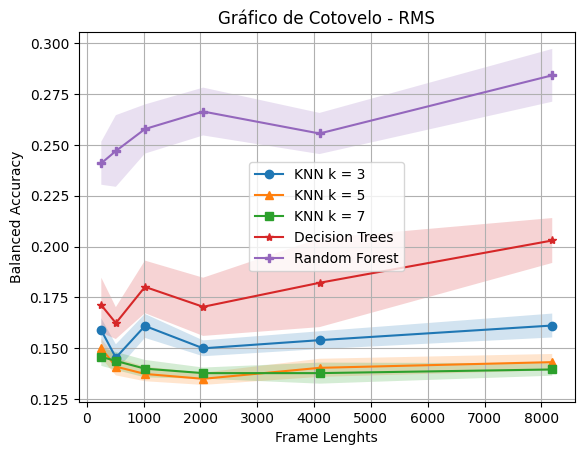

In [25]:
plt.plot(frame_lenghts, scoresmeans[0], label = 'KNN k = 3', marker = 'o')
plt.plot(frame_lenghts, scoresmeans[1], label = 'KNN k = 5', marker = '^')
plt.plot(frame_lenghts, scoresmeans[2], label = 'KNN k = 7', marker = 's')
plt.plot(frame_lenghts, scoresmeans[3], label = 'Decision Trees', marker = '*')
plt.plot(frame_lenghts, scoresmeans[4], label = 'Random Forest', marker = 'P')

plt.fill_between(frame_lenghts, scoresmeans[0] + scoressds[0], scoresmeans[0] - scoressds[0], alpha = 0.2)
plt.fill_between(frame_lenghts, scoresmeans[1] + scoressds[1], scoresmeans[1] - scoressds[1], alpha = 0.2)
plt.fill_between(frame_lenghts, scoresmeans[2] + scoressds[2], scoresmeans[2] - scoressds[2], alpha = 0.2)
plt.fill_between(frame_lenghts, scoresmeans[3] + scoressds[3], scoresmeans[3] - scoressds[3], alpha = 0.2)
plt.fill_between(frame_lenghts, scoresmeans[4] + scoressds[4], scoresmeans[4] - scoressds[4], alpha = 0.2)

plt.legend()
plt.grid()
plt.ylabel('Balanced Accuracy')
plt.xlabel('Frame Lenghts')
plt.title('Gráfico de Cotovelo - RMS')
plt.savefig('rms.pdf')
plt.show()


In [72]:
  dfmfcc = featureExtraction(songs, 'mfcc', 44100, frame=1024)


In [ ]:
knnscores3 = []
knnscores5 = []
knnscores7 = []
dtscores = []
rfscores = []
seeds = [14, 42, 60, 87, 113, 156, 211, 456, 917, 1001]

for seed in seeds:
  knnscores3.append(elbowKNN([dfmfcc], n_neigh = 3, seed = seed))
  knnscores5.append(elbowKNN([dfmfcc], n_neigh = 5, seed = seed))
  knnscores7.append(elbowKNN([dfmfcc], n_neigh = 7, seed = seed))

  dtscores.append(elbowTree([dfmfcc], seed = seed))
  rfscores.append(elbowRF([dfmfcc], seed = seed))